# Good Advice - Book Recommendation

Algorithm: item-based kNN Collaborative Filtering with content-based filtering on cold-start

Dataset: Book-crossing Dataset

Authors: Dima, Jiska, Noah, Yana

## Installing Requirements

The notebook should already have most of the available packages. But in case it does not have them, please run the below code block to install all the required packages.

In [1]:
#pip install -r RecSys/requirements.txt

## Import Dependencies

Let's start of by importing the required packages that we use for this Recommender System.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Helper Functions

In [3]:
def get_by_range(dataset, lower_bound = None, upper_bound = None, key = 'Year-Of-Publication'):
    if (lower_bound is not None):
        dataset = dataset[dataset[key] >= lower_bound]
    if (upper_bound is not None):
        dataset = dataset[dataset[key] <= upper_bound]
    
    return dataset

In [4]:
def get_by_frequency(dataset, freq = None, key = 'ISBN'):
    local_dist = dataset[key].value_counts().sort_index()
    filtered_dist = pd.DataFrame(local_dist[local_dist >= freq])

    return dataset[dataset[key].isin(filtered_dist.index)]

In [5]:
def merge(A = None, B = None, key = 'ISBN', how='inner', duplicates=True):
    if A is None or B is None:
        return []

    dataset = pd.merge(A[key], B, on=key, how=how)

    if duplicates == False:
        dataset = dataset.drop_duplicates(key)
    
    return dataset

In [6]:
def get_book_count_within_frequency(books = None, ratings = None, freq=20, book_name_text='books'):
    ratings_in_freq = get_by_frequency(ratings, freq=freq, key='ISBN')
    books_in_freq = merge(ratings_in_freq, books, duplicates=False)

    print(f"There are {books_in_freq.size} {book_name_text} with a minimum of {freq} ratings")

    return books_in_freq, ratings_in_freq

In [7]:
def get_user_count_within_frequency(users = None, ratings = None, freq=20, user_name_text='books'):
    ratings_in_freq = get_by_frequency(ratings, freq=freq, key='User-ID')
    users_in_freq = merge(ratings_in_freq, users, key='User-ID', duplicates=False)

    print(f"There are {users_in_freq.size} {user_name_text} that gave a minimum of {freq} ratings")

    return users_in_freq, ratings_in_freq

## Reading Data

First read the necessary data from the Book-Crossing Dataset.

In [8]:
users = pd.read_csv('BX-Users.csv', sep=';', encoding='cp1252', on_bad_lines="skip", low_memory=False)
books = pd.read_csv('BX-Books.csv', sep=";", encoding='cp1252', on_bad_lines="skip", low_memory=False)
book_ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', encoding='cp1252', on_bad_lines="skip", low_memory=False)

## Initial Data Structure

Below the initial data structures of all 3 datatables can be seen.

### Users

In [9]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


### Books

In [10]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


### Book Ratings

In [11]:
book_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


## Data Exploration

### Books

Books have ISBN, Book-Author, Year-Of-Publication, Publisher, Image-URL-S, Image-URL-M, Image-URL-L.

In [12]:
books.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], inplace=True)
books = books.astype({'ISBN': 'string', 'Book-Title': 'string', 'Book-Author': 'string', 'Publisher': 'string'})

Let's first look at the Year-Of-Publication column of the Books. Printing all the unique publication date values, gives us some potentially "odd" values, such as NaN, extremely low values (such as 5) or values that indicate a release in the future (such as 2030).

In [13]:
print(sorted(books['Year-Of-Publication'].unique()))

['0', '1376', '1378', '1806', '1897', '1900', '1901', '1902', '1904', '1906', '1908', '1909', '1910', '1911', '1914', '1917', '1919', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2008', '2010', '2011', '2012', '2020', '2021', '2024', '2026', '2030', '2037', '2038', '2050', 'DK Publishing Inc', 'Gallimard']


We can see here that we have some books that are really old, books that are released in the future, and book with text as a publication date, which might be wrong data.

Let's start by checking out the text publication dates, to see what is going on there.

In [14]:
books[books['Year-Of-Publication'].apply(lambda x: x == 'DK Publishing Inc' or x == 'Gallimard')]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...


We can see that something went wrong with reading the CSV to the dataframe on the titles of these movies. So we can just patch this up such that the columns are back in their correct positions.

In [15]:
books.loc[books['ISBN'] == '078946697X', 'Year-Of-Publication'] = 2000
books.loc[books['ISBN'] == '078946697X', 'Book-Author'] = 'Michael Teitelbaum'
books.loc[books['ISBN'] == '078946697X', 'Publisher'] = 'DK Publishing Inc'
books.loc[books['ISBN'] == '078946697X', 'Book-Title'] = 'K Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'

books.loc[books['ISBN'] == '0789466953', 'Year-Of-Publication'] = 2000
books.loc[books['ISBN'] == '0789466953', 'Book-Author'] = 'James Buckley'
books.loc[books['ISBN'] == '0789466953', 'Publisher'] = 'DK Publishing Inc'
books.loc[books['ISBN'] == '0789466953', 'Book-Title'] = 'K Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)'

books.loc[books['ISBN'] == '2070426769', 'Year-Of-Publication'] = 2003
books.loc[books['ISBN'] == '2070426769', 'Book-Author'] = 'jean-marie gustave le clézio'
books.loc[books['ISBN'] == '2070426769', 'Publisher'] = 'Gallimard'
books.loc[books['ISBN'] == '2070426769', 'Book-Title'] = 'Peuple du ciel, suivi de "Les Bergers"'

In [16]:
books[books['Year-Of-Publication'].apply(lambda x: x == 'DK Publishing Inc' or x == 'Gallimard')]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher


We can now see that there are no publications with texts anymore.

In [17]:
books[books['ISBN'].apply(lambda x: x == '078946697X' or x == '0789466953' or x == '2070426769')]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"K Readers: Creating the X-Men, How It All Bega...",Michael Teitelbaum,2000,DK Publishing Inc
220731,2070426769,"Peuple du ciel, suivi de ""Les Bergers""",jean-marie gustave le clézio,2003,Gallimard
221678,0789466953,"K Readers: Creating the X-Men, How Comic Books...",James Buckley,2000,DK Publishing Inc


and taking a look at the three specific ISBNs gives us that the structure of the data is correct again.

Now that we have done some data wrangling, we still need to look at the remaining odd publication years.

In [18]:
books = books.astype({'Year-Of-Publication': np.uint32})
all_books = books['ISBN'].count();
invalid_book_publications = books[(books['Year-Of-Publication'] < 1850) | (books['Year-Of-Publication'] > 2006)]
valid_book_publications = books[(books['Year-Of-Publication'] >= 1850) & (books['Year-Of-Publication'] <= 2006)]
invalid_book_publications_count = invalid_book_publications['ISBN'].count()
valid_book_publications_count = valid_book_publications['ISBN'].count()

In [19]:
invalid_book_publications_percentage = (invalid_book_publications_count / all_books) * 100

print(f"{invalid_book_publications_count} books have odd publication years")
print(f"{invalid_book_publications_percentage:.2f}% of books have an unrealistic publication year")

4644 books have odd publication years
1.71% of books have an unrealistic publication year


In [20]:
all_books_distribution = books['Year-Of-Publication'].value_counts().sort_index()
invalid_books_distribution = invalid_book_publications['Year-Of-Publication'].value_counts().sort_index()
valid_books_distribution = valid_book_publications['Year-Of-Publication'].value_counts().sort_index()

Below we can see the complete graph on both valid and invalid data. It's a bit rough to see, so we'll separate them in the next few blocks.

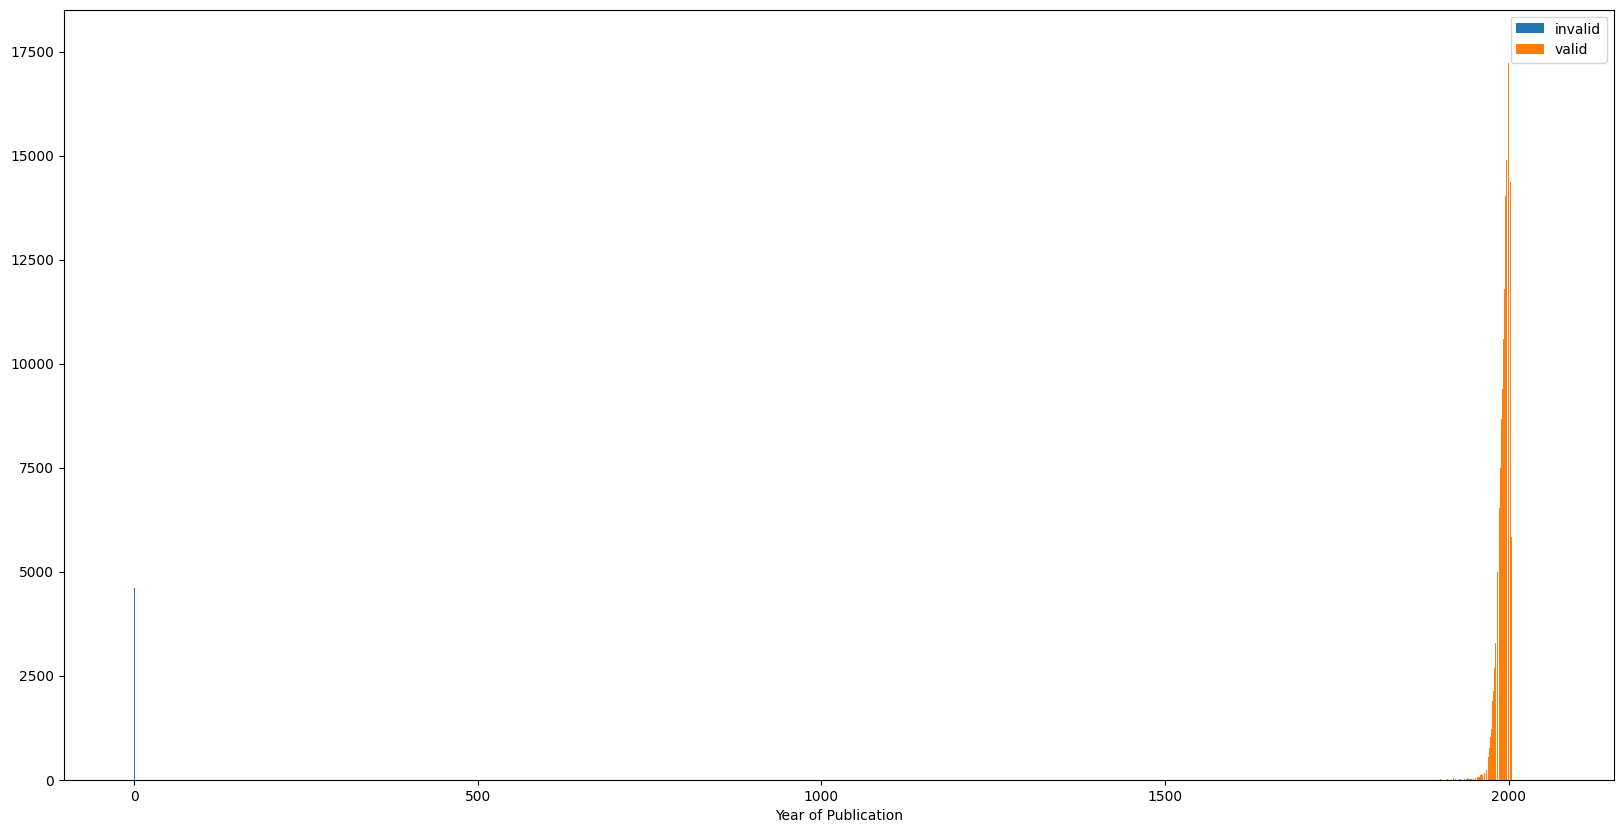

In [21]:
plt.figure(figsize=(20, 10))
plt.bar(invalid_books_distribution.index, invalid_books_distribution.values, label='invalid')
plt.bar(valid_books_distribution.index, valid_books_distribution.values, label='valid')
plt.xlabel('Year of Publication')
plt.legend()
plt.show()

Taking a better look at the invalid data, we can see that it's mostly books with a publication year at 0, and some then at some years before 1850 and after 2006, but not enough to be shown in the graph.

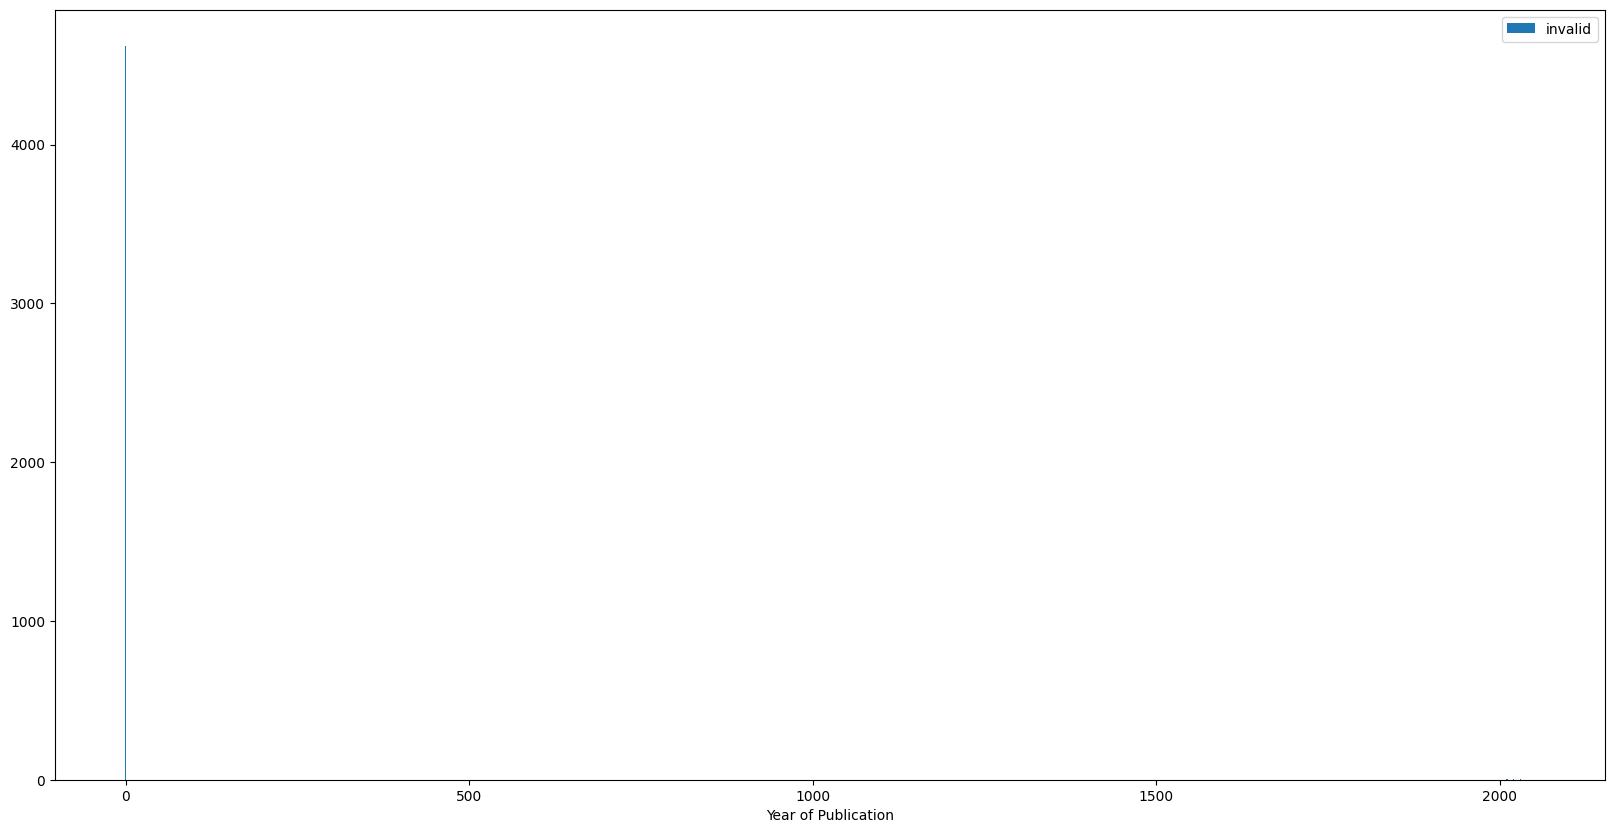

In [22]:
plt.figure(figsize=(20, 10))
plt.bar(invalid_books_distribution.index, invalid_books_distribution.values, label='invalid')
plt.xlabel('Year of Publication')
plt.legend()
plt.show()

Looking at the "valid" data between 1850 to 2005, we can see that most books have been released from the 1960s till 2005.

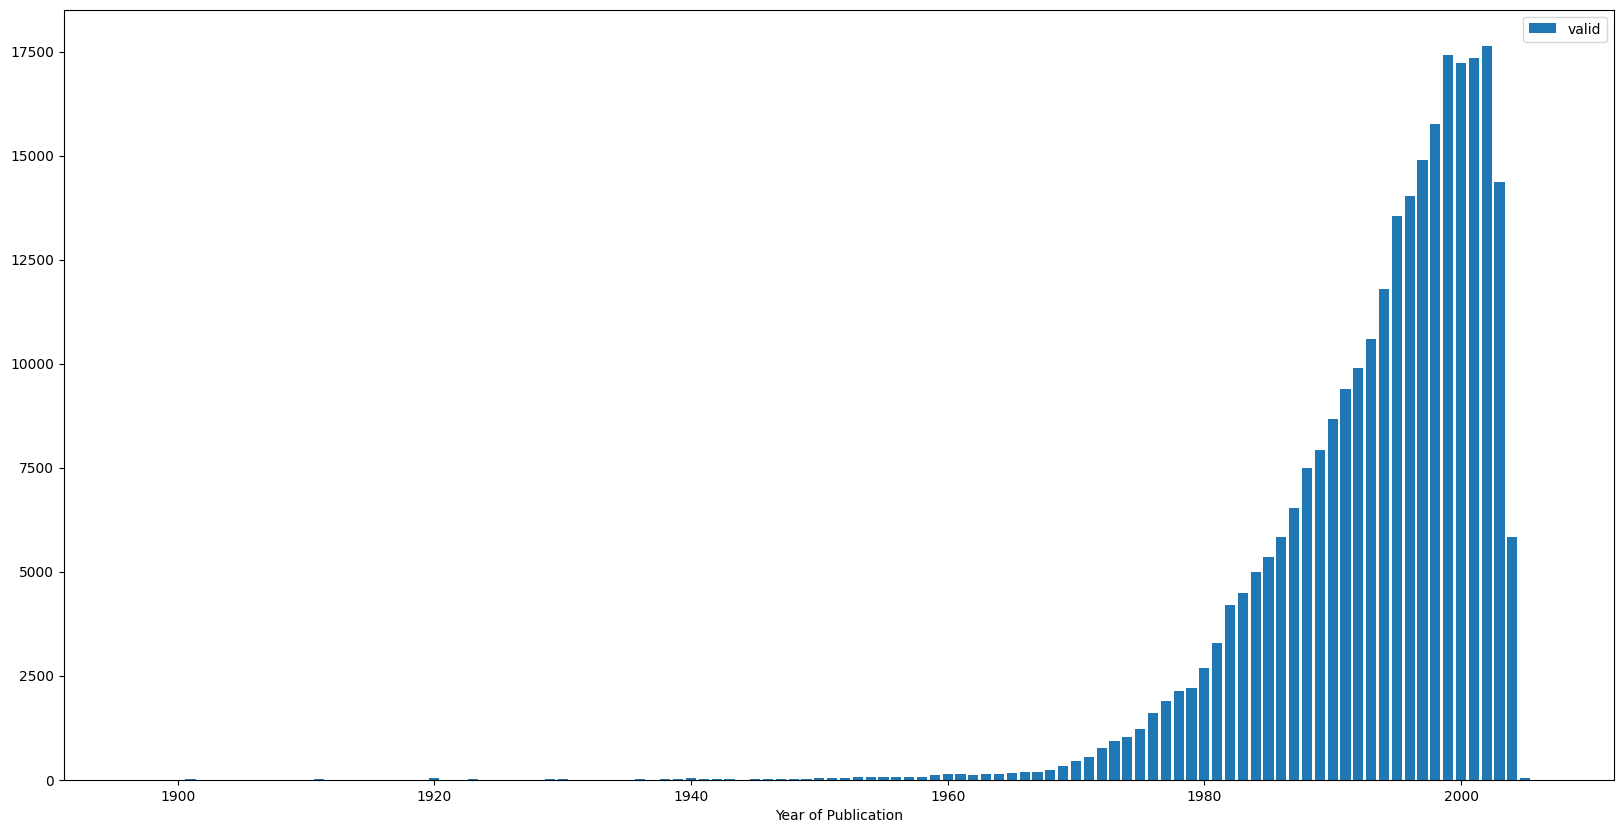

In [23]:
plt.figure(figsize=(20, 10))
plt.bar(valid_books_distribution.index, valid_books_distribution.values, label='valid')
plt.xlabel('Year of Publication')
plt.legend()
plt.show()

Let's look a bit better into the books and see how many of those books actually had valid ratings (ratings > 0).

First join the books with the ratings, such that we know which books were ratings.

In [24]:
all_books_with_ratings = book_ratings.merge(books.set_index('ISBN'), on='ISBN', how='inner')
invalid_books_with_ratings = book_ratings.merge(invalid_book_publications.set_index('ISBN'), on='ISBN', how='inner')
valid_books_with_ratings = book_ratings.merge(valid_book_publications.set_index('ISBN'), on='ISBN', how='inner')

We should remove books with a 0 rating, as these are books that did not receive a rating (yet).

In [25]:
all_books_with_ratings_nonzero = all_books_with_ratings[all_books_with_ratings['Book-Rating'].apply(lambda x: x > 0)]
invalid_books_with_ratings_nonzero = invalid_books_with_ratings[invalid_books_with_ratings['Book-Rating'].apply(lambda x: x > 0)]
valid_books_with_ratings_nonzero = valid_books_with_ratings[valid_books_with_ratings['Book-Rating'].apply(lambda x: x > 0)]

We then compute the distributions

In [26]:
all_books_with_ratings_distribution = all_books_with_ratings['ISBN'].value_counts().sort_index()
invalid_books_with_ratings_distribution = invalid_books_with_ratings['ISBN'].value_counts().sort_index()
valid_books_with_ratings_distribution = valid_books_with_ratings['ISBN'].value_counts().sort_index()

all_books_with_ratings_nonzero_distribution = all_books_with_ratings_nonzero['ISBN'].value_counts().sort_index()
invalid_books_with_ratings_nonzero_distribution = invalid_books_with_ratings_nonzero['ISBN'].value_counts().sort_index()
valid_books_with_ratings_nonzero_distribution = valid_books_with_ratings_nonzero['ISBN'].value_counts().sort_index()

and check how many books got at least one rating (first three including 0 ratings, second three excluding 0 ratings)

In [27]:
print(f"{all_books_with_ratings_distribution.count()} out of {all_books} books have been rated at least once.")
print(f"{invalid_books_with_ratings_distribution.count()} out of {invalid_book_publications_count} potentially invalid books have been rated at least once.")
print(f"{valid_books_with_ratings_distribution.count()} out of {valid_book_publications_count} valid books have been rated at least once.")

print(f"{all_books_with_ratings_nonzero_distribution.count()} out of {all_books} books have been rated at least once higher than 0.")
print(f"{invalid_books_with_ratings_nonzero_distribution.count()} out of {invalid_book_publications_count} potentially invalid books have been rated at least once higher than 0.")
print(f"{valid_books_with_ratings_nonzero_distribution.count()} out of {valid_book_publications_count} valid books have been rated at least once higher than 0.")

270151 out of 271360 books have been rated at least once.
4623 out of 4644 potentially invalid books have been rated at least once.
265528 out of 266716 valid books have been rated at least once.
149836 out of 271360 books have been rated at least once higher than 0.
2738 out of 4644 potentially invalid books have been rated at least once higher than 0.
147098 out of 266716 valid books have been rated at least once higher than 0.


We would also need to have a minimum frequency to reach reliable results in our recommendations. So we filter by min_rating_count and see how many books are left.

In [28]:
min_rating_count = 20
print(f"{all_books_with_ratings_distribution[all_books_with_ratings_distribution > min_rating_count].count()} out of {all_books} books have been rated at least {min_rating_count} times.")
print(f"{invalid_books_with_ratings_distribution[invalid_books_with_ratings_distribution > min_rating_count].count()} out of {invalid_book_publications_count} potentially invalid books have been rated at least {min_rating_count} times.")
print(f"{valid_books_with_ratings_distribution[valid_books_with_ratings_distribution > min_rating_count].count()} out of {valid_book_publications_count} valid books have been rated at least {min_rating_count} times.")

print(f"{all_books_with_ratings_nonzero_distribution[all_books_with_ratings_nonzero_distribution > min_rating_count].count()} out of {all_books} books have been rated at least {min_rating_count} times with a rating higher than 0.")
print(f"{invalid_books_with_ratings_nonzero_distribution[invalid_books_with_ratings_nonzero_distribution > min_rating_count].count()} out of {invalid_book_publications_count} potentially invalid books have been rated at least {min_rating_count} times with a rating higher than 0.")
print(f"{valid_books_with_ratings_nonzero_distribution[valid_books_with_ratings_nonzero_distribution > min_rating_count].count()} out of {valid_book_publications_count} valid books have been rated at least {min_rating_count} times with a rating higher than 0.")

6863 out of 271360 books have been rated at least 20 times.
74 out of 4644 potentially invalid books have been rated at least 20 times.
6789 out of 266716 valid books have been rated at least 20 times.
1988 out of 271360 books have been rated at least 20 times with a rating higher than 0.
17 out of 4644 potentially invalid books have been rated at least 20 times with a rating higher than 0.
1971 out of 266716 valid books have been rated at least 20 times with a rating higher than 0.


Above we can see that if we put a rating constraint on the books, that we'd get much less book that are going to be "valid".

For experimental purposes, we'll create a couple of datasets such that we can potentially see differences between the constraints and to find a good fit in the to-use dataset.

In [29]:
# Only Valid Books
valid_only_books_no_rating_req = get_by_range(books, lower_bound=1850, upper_bound=2006)


# Valid + Potentially Invalid Books
all_books_no_rating_req = get_by_range(books, lower_bound=0, upper_bound=2006)

In [30]:
valid_books_book_ratings = merge(book_ratings, valid_only_books_no_rating_req)
all_books_book_ratings = merge(book_ratings, all_books_no_rating_req)

In [31]:
# Book Subsets with min 2 ratings
valid_only_books_2_rating_req, valid_only_books_book_rating_2_rating_req = get_book_count_within_frequency(books=books, ratings=valid_books_book_ratings, freq=2, book_name_text='valid books')
all_books_2_rating_req, all_books_book_rating_2_rating_req = get_book_count_within_frequency(books=books, ratings=all_books_book_ratings, freq=2, book_name_text='valid + potentially invalid books')

There are 611595 valid books with a minimum of 2 ratings
There are 622445 valid + potentially invalid books with a minimum of 2 ratings


In [32]:
# Book Subsets with min 5 ratings
valid_only_books_5_rating_req, valid_only_books_book_rating_5_rating_req = get_book_count_within_frequency(books=books, ratings=valid_books_book_ratings, freq=5, book_name_text='valid books')
all_books_5_rating_req, all_books_book_rating_5_rating_req = get_book_count_within_frequency(books=books, ratings=all_books_book_ratings, freq=5, book_name_text='valid + potentially invalid books')

There are 201265 valid books with a minimum of 5 ratings
There are 204550 valid + potentially invalid books with a minimum of 5 ratings


In [33]:
# Book Subsets with min 10 ratings
valid_only_books_10_rating_req, valid_only_books_book_rating_10_rating_req = get_book_count_within_frequency(books=books, ratings=valid_books_book_ratings, freq=10, book_name_text='valid books')
all_books_10_rating_req, all_books_book_rating_10_rating_req = get_book_count_within_frequency(books=books, ratings=all_books_book_ratings, freq=10, book_name_text='valid + potentially invalid books')

There are 86145 valid books with a minimum of 10 ratings
There are 87385 valid + potentially invalid books with a minimum of 10 ratings


In [34]:
# Book Subsets with min 20 ratings
valid_only_books_20_rating_req, valid_only_books_book_rating_20_rating_req = get_book_count_within_frequency(books=books, ratings=valid_books_book_ratings, freq=20, book_name_text='valid books')
all_books_20_rating_req, all_books_book_rating_20_rating_req = get_book_count_within_frequency(books=books, ratings=all_books_book_ratings, freq=20, book_name_text='valid + potentially invalid books')

There are 35955 valid books with a minimum of 20 ratings
There are 36345 valid + potentially invalid books with a minimum of 20 ratings


In [35]:
# Book Subsets with min 50 ratings
valid_only_books_50_rating_req, valid_only_books_book_rating_50_rating_req = get_book_count_within_frequency(books=books, ratings=valid_books_book_ratings, freq=50, book_name_text='valid books')
all_books_50_rating_req, all_books_book_rating_50_rating_req = get_book_count_within_frequency(books=books, ratings=all_books_book_ratings, freq=50, book_name_text='valid + potentially invalid books')

There are 10735 valid books with a minimum of 50 ratings
There are 10805 valid + potentially invalid books with a minimum of 50 ratings


In [36]:
# Book Subsets with min 75 ratings
valid_only_books_75_rating_req, valid_only_books_book_rating_75_rating_req = get_book_count_within_frequency(books=books, ratings=valid_books_book_ratings, freq=75, book_name_text='valid books')
all_books_75_rating_req, all_books_book_rating_75_rating_req = get_book_count_within_frequency(books=books, ratings=all_books_book_ratings, freq=75, book_name_text='valid + potentially invalid books')

There are 5770 valid books with a minimum of 75 ratings
There are 5795 valid + potentially invalid books with a minimum of 75 ratings


In [37]:
# Book Subsets with min 100 ratings
valid_only_books_100_rating_req, valid_only_books_book_rating_100_rating_req = get_book_count_within_frequency(books=books, ratings=valid_books_book_ratings, freq=100, book_name_text='valid books')
all_books_100_rating_req, all_books_book_rating_100_rating_req = get_book_count_within_frequency(books=books, ratings=all_books_book_ratings, freq=100, book_name_text='valid + potentially invalid books')

There are 3625 valid books with a minimum of 100 ratings
There are 3635 valid + potentially invalid books with a minimum of 100 ratings


Above, we only took the books with frequency ratings: 2, 20, 50, 75 and 100.

The first notion we can make between the two subsets (only valid books and both valid and potentially invalid books) is that the potentially invalid books get removed from the eventual subsets on all frequency requirements.

On the notion of frequencies, we think that having only 2 ratings for each book is not going to be enough. Even though we'd have a big sample of books, most of those books are going to have a low amount of ratings.We also think that the frequency limits of 75 and 100 give to few results, in this aspect. So either 20 or 50 as a minimum seems to be the better options. However, before making any final decisions, we'll first look at the user data.

### Users

Let's first look at the Age column of the Users. Printing all the unique publication date values, gives us some potentially "odd" values such as Nan , extremely low values (such as 0) or extremely high values (such as 200+).

In [38]:
print(sorted(users['Age'].unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

Looking at the explanation of the NaN values in the dataset, it'll be set to NaN if Age was not provided. So users with age NaN are valid users, but just did not provide their age.

However, we may want to separate NaN aged users if we want to take Age into account as a feature on CB recommendations.

It's very unlikely for extremely young children to give ratings and similarly for elderly people from a really high age. Let's create two subsets, one with any age allowed and one with only people between 7 to 115.

In [39]:
users = users.astype({'User-ID': 'Int64', 'Location': 'string', 'Age': 'Int64'})

In [40]:
all_users_count = users['User-ID'].count();
invalid_users_age = users
valid_users_age = users[((users['Age'] >= 8) & (users['Age'] <= 114)) | (np.isnan(users['Age']))]
invalid_users_age_count = invalid_users_age['User-ID'].count()
valid_users_age_count = valid_users_age['User-ID'].count()
nan_users_age = users[users['Age'].isnull()]
nan_users_age_count = users['Age'].isnull().sum()

In [41]:
invalid_users_age_percentage = (invalid_users_age_count / all_users_count) * 100

print(f"{invalid_users_age_count} users have odd age (too young or too old)")
print(f"{invalid_users_age_percentage:.2f}% of users have an unrealistic age to place ratings")
print(f"{nan_users_age_count} users have not given their age")

278858 users have odd age (too young or too old)
100.00% of users have an unrealistic age to place ratings
110762 users have not given their age


In [42]:
all_users_distribution = users['Age'].value_counts().sort_index()
invalid_users_distribution = invalid_users_age['Age'].value_counts().sort_index()
valid_users_distribution = valid_users_age['Age'].value_counts().sort_index()

Below we can see the complete graph on both valid and invalid data.

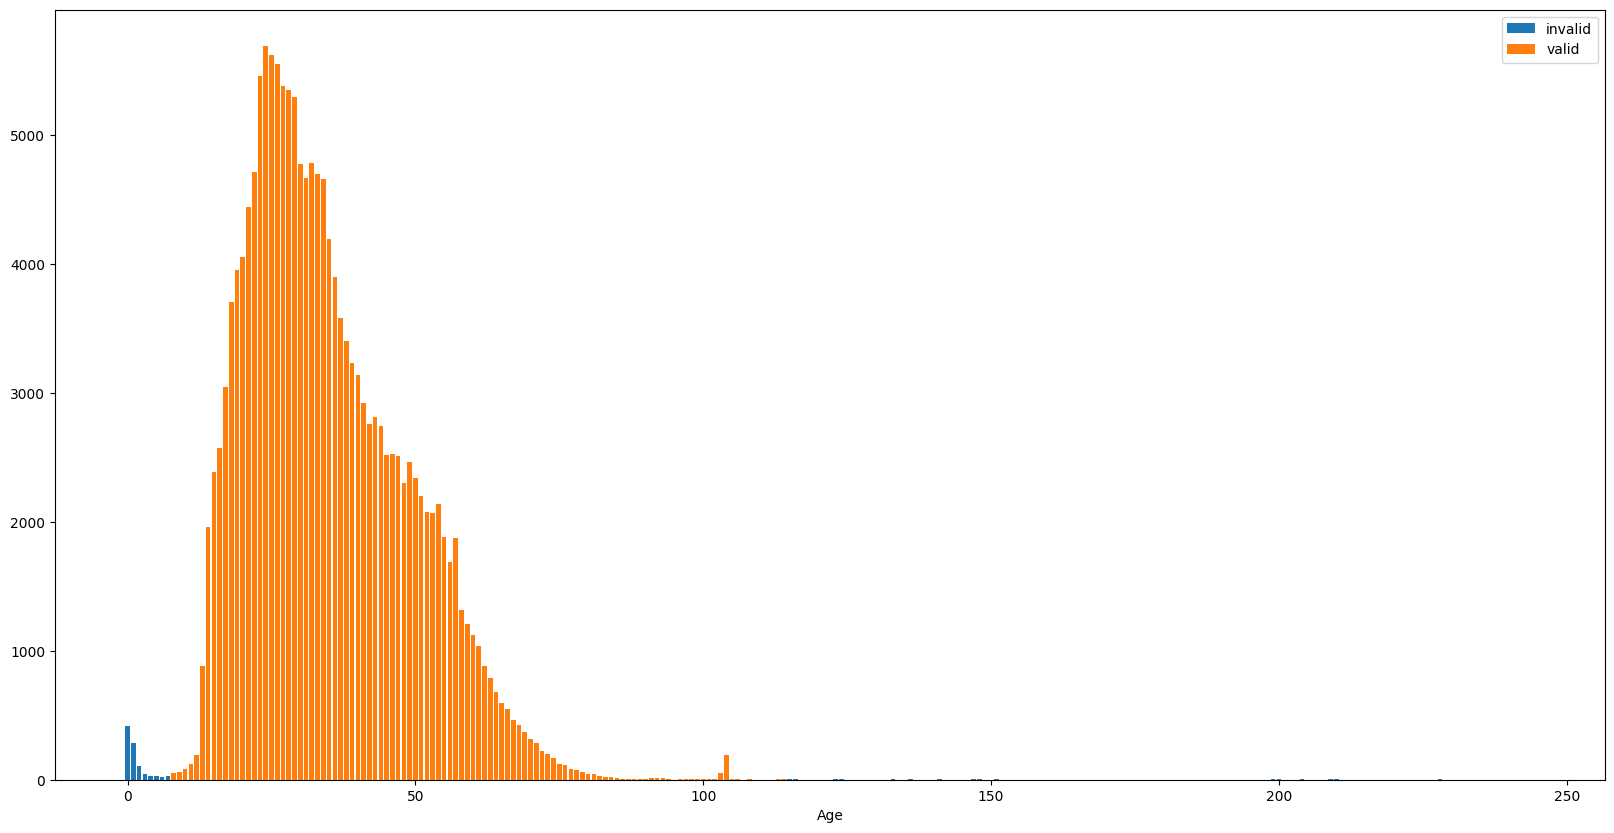

In [43]:
plt.figure(figsize=(20, 10))
plt.bar(invalid_users_distribution.index, invalid_users_distribution.values, label='invalid')
plt.bar(valid_users_distribution.index, valid_users_distribution.values, label='valid')
plt.xlabel('Age')
plt.legend()
plt.show()

The above graph clearly shows the valid data, but seems to not visually show the invalid data that well. So let's zoom in on both subsets a bit more.

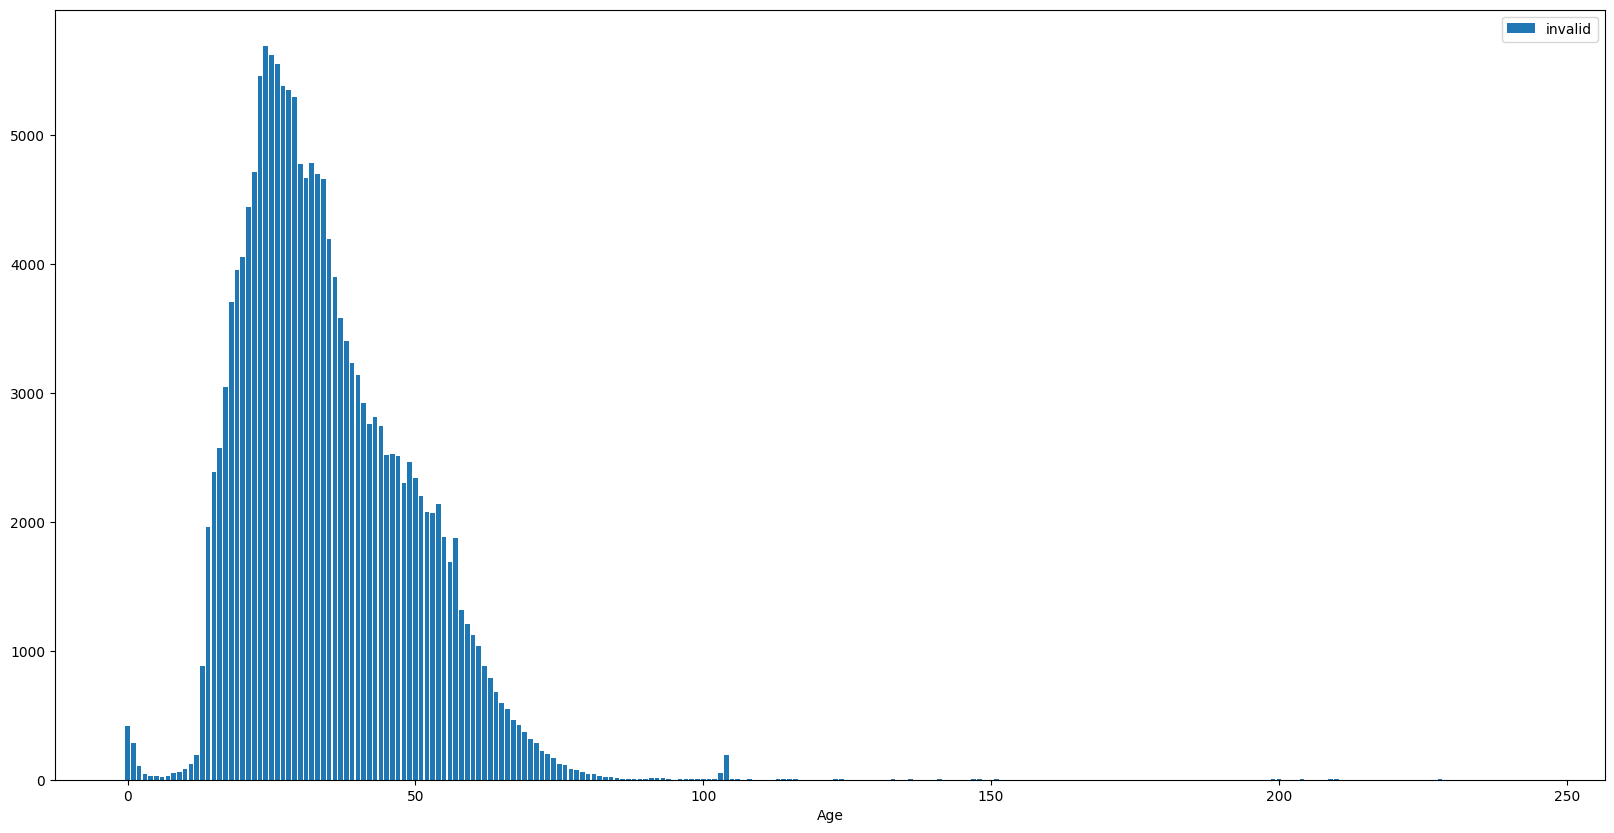

In [44]:
plt.figure(figsize=(20, 10))
plt.bar(invalid_users_distribution.index, invalid_users_distribution.values, label='invalid')
plt.xlabel('Age')
plt.legend()
plt.show()

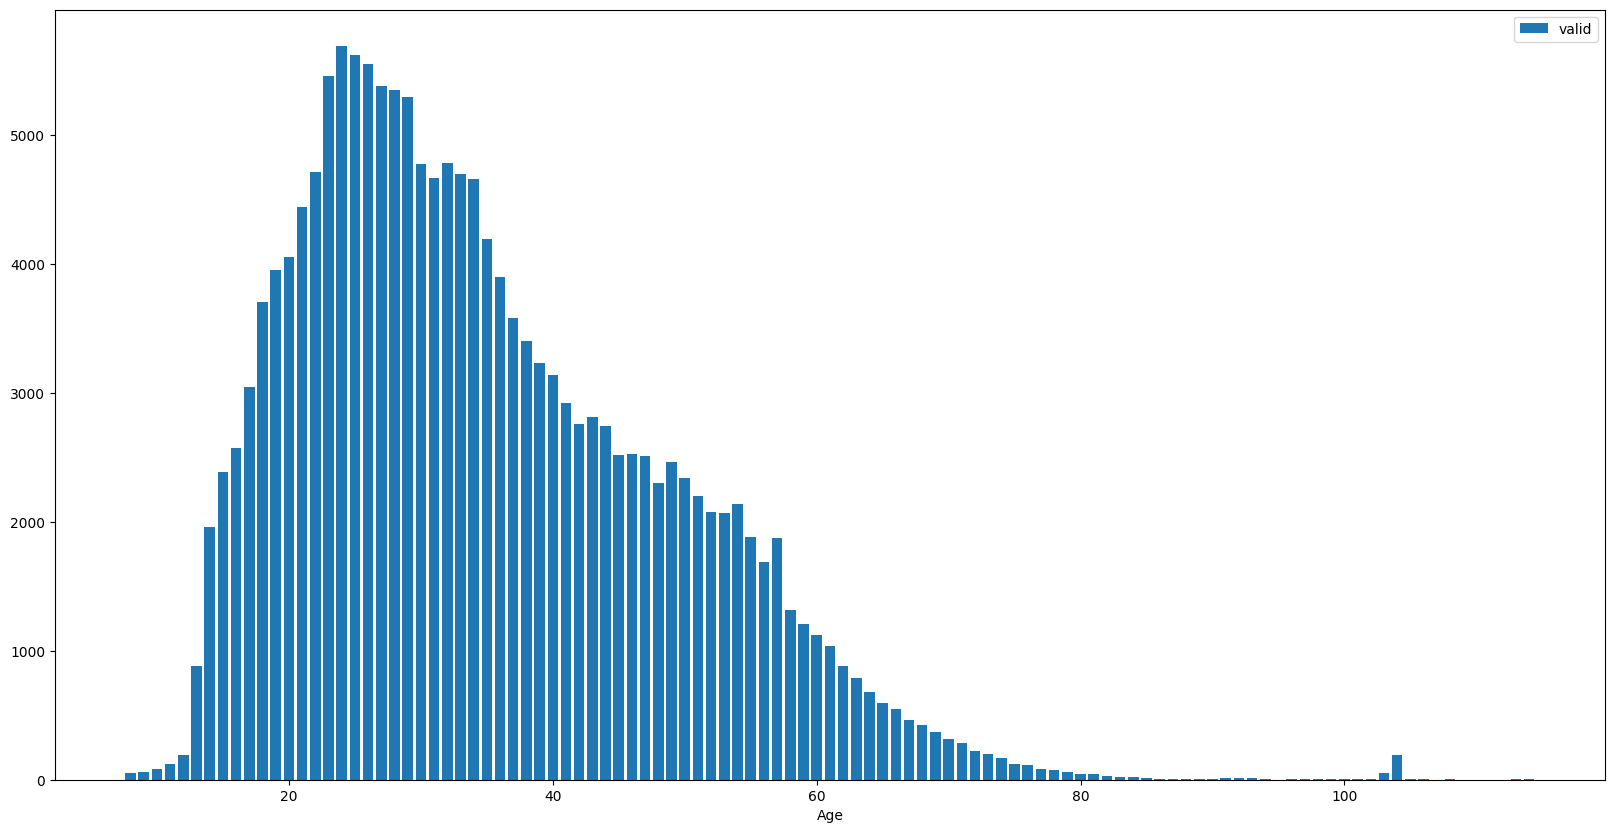

In [45]:
plt.figure(figsize=(20, 10))
plt.bar(valid_users_distribution.index, valid_users_distribution.values, label='valid')
plt.xlabel('Age')
plt.legend()
plt.show()

A quick note that NaN aged users are not displayed in the graph. Though, they belong to the valid users (as they simply did not provide their age, we still consider them valid).

Let's look a bit better into the users and see how many ratings they got.

In [46]:
all_users_with_ratings = book_ratings.merge(users.set_index('User-ID'), on='User-ID', how='inner')
invalid_users_with_ratings = book_ratings.merge(invalid_users_age.set_index('User-ID'), on='User-ID', how='inner')
valid_users_with_ratings = book_ratings.merge(valid_users_age.set_index('User-ID'), on='User-ID', how='inner')

In [47]:
all_users_with_ratings_nonzero = all_users_with_ratings[all_users_with_ratings['Book-Rating'].apply(lambda x: x > 0)]
invalid_users_with_ratings_nonzero = invalid_users_with_ratings[invalid_users_with_ratings['Book-Rating'].apply(lambda x: x > 0)]
valid_users_with_ratings_nonzero = valid_users_with_ratings[valid_users_with_ratings['Book-Rating'].apply(lambda x: x > 0)]

We then compute the distributions

In [48]:
all_users_with_ratings_distribution = all_users_with_ratings['User-ID'].value_counts().sort_index()
invalid_users_with_ratings_distribution = invalid_users_with_ratings['User-ID'].value_counts().sort_index()
valid_users_with_ratings_distribution = valid_users_with_ratings['User-ID'].value_counts().sort_index()

all_users_with_ratings_nonzero_distribution = all_users_with_ratings_nonzero['User-ID'].value_counts().sort_index()
invalid_users_with_ratings_nonzero_distribution = invalid_users_with_ratings_nonzero['User-ID'].value_counts().sort_index()
valid_users_with_ratings_nonzero_distribution = valid_users_with_ratings_nonzero['User-ID'].value_counts().sort_index()


and check how many users made at least one rating (first three including 0 ratings, second three excluding 0 ratings)

In [49]:
print(f"{all_users_with_ratings_distribution.count()} out of {all_users_count} users have rated at least one book.")
print(f"{invalid_users_with_ratings_distribution.count()} out of {invalid_users_age_count} invalid users have rated at least one book.")
print(f"{valid_users_with_ratings_distribution.count()} out of {valid_users_age_count} valid users have rated at least one book.")

print(f"{all_users_with_ratings_nonzero_distribution.count()} out of {all_users_count} users have rated at least one book higher than 0.")
print(f"{invalid_users_with_ratings_nonzero_distribution.count()} out of {invalid_users_age_count} invalid users have rated at least one book higher than 0.")
print(f"{valid_users_with_ratings_nonzero_distribution.count()} out of {valid_users_age_count} valid users have rated at least one book higher than 0.")

105283 out of 278858 users have rated at least one book.
105283 out of 278858 invalid users have rated at least one book.
61709 out of 167055 valid users have rated at least one book.
77805 out of 278858 users have rated at least one book higher than 0.
77805 out of 278858 invalid users have rated at least one book higher than 0.
46411 out of 167055 valid users have rated at least one book higher than 0.


We would also need to have a minimum frequency to reach reliable results in our recommendations. So we filter by min_rating_count and see how many users are left.

In [50]:
min_rating_count = 20
print(f"{all_users_with_ratings_distribution[all_users_with_ratings_distribution > min_rating_count].count()} out of {all_users_count} users have rated at least {min_rating_count} books.")
print(f"{invalid_users_with_ratings_distribution[invalid_users_with_ratings_distribution > min_rating_count].count()} out of {invalid_users_age_count} invalid users have rated at least {min_rating_count} books.")
print(f"{valid_users_with_ratings_distribution[valid_users_with_ratings_distribution > min_rating_count].count()} out of {valid_users_age_count} valid users have rated at least {min_rating_count} books.")

print(f"{all_users_with_ratings_nonzero_distribution[all_users_with_ratings_nonzero_distribution > min_rating_count].count()} out of {all_users_count} users have rated at least {min_rating_count} books with a rating higher than 0.")
print(f"{invalid_users_with_ratings_nonzero_distribution[invalid_users_with_ratings_nonzero_distribution > min_rating_count].count()} out of {invalid_users_age_count} invalid users have rated at least {min_rating_count} books with a rating higher than 0.")
print(f"{valid_users_with_ratings_nonzero_distribution[valid_users_with_ratings_nonzero_distribution > min_rating_count].count()} out of {valid_users_age_count} valid users have rated at least {min_rating_count} books with a rating higher than 0.")

7078 out of 278858 users have rated at least 20 books.
7078 out of 278858 invalid users have rated at least 20 books.
5273 out of 167055 valid users have rated at least 20 books.
3521 out of 278858 users have rated at least 20 books with a rating higher than 0.
3521 out of 278858 invalid users have rated at least 20 books with a rating higher than 0.
2717 out of 167055 valid users have rated at least 20 books with a rating higher than 0.


Above we can see that if we put a rating constraint on the users, that we'd get much less users that are going to be "valid".

For experimental purposes, we'll create a couple of datasets such that we can potentially see differences between the constraints and to find a good fit in the to-use dataset.

In [51]:
# User subsets with min 0 ratings given
valid_users_0_rating_req, valid_users_book_rating_0_rating_req = get_user_count_within_frequency(users=valid_users_age, ratings=book_ratings, freq=0, user_name_text='valid users')
invalid_users_0_rating_req, invalid_users_book_rating_0_rating_req = get_user_count_within_frequency(users=invalid_users_age, ratings=book_ratings, freq=0, user_name_text='valid + invalid users')

There are 185127 valid users that gave a minimum of 0 ratings
There are 315849 valid + invalid users that gave a minimum of 0 ratings


In [52]:
# User subsets with min 1 ratings given
valid_users_1_rating_req, valid_users_book_rating_1_rating_req = get_user_count_within_frequency(users=valid_users_age, ratings=book_ratings, freq=1, user_name_text='valid users')
invalid_users_1_rating_req, invalid_users_book_rating_1_rating_req = get_user_count_within_frequency(users=invalid_users_age, ratings=book_ratings, freq=1, user_name_text='valid + invalid users')

There are 185127 valid users that gave a minimum of 1 ratings
There are 315849 valid + invalid users that gave a minimum of 1 ratings


In [53]:
# User subsets with min 2 ratings given
valid_users_2_rating_req, valid_users_book_rating_2_rating_req = get_user_count_within_frequency(users=valid_users_age, ratings=book_ratings, freq=2, user_name_text='valid users')
invalid_users_2_rating_req, invalid_users_book_rating_2_rating_req = get_user_count_within_frequency(users=invalid_users_age, ratings=book_ratings, freq=2, user_name_text='valid + invalid users')

There are 89568 valid users that gave a minimum of 2 ratings
There are 138351 valid + invalid users that gave a minimum of 2 ratings


In [54]:
# User subsets with min 5 ratings given
valid_users_5_rating_req, valid_users_book_rating_5_rating_req = get_user_count_within_frequency(users=valid_users_age, ratings=book_ratings, freq=5, user_name_text='valid users')
invalid_users_5_rating_req, invalid_users_book_rating_5_rating_req = get_user_count_within_frequency(users=invalid_users_age, ratings=book_ratings, freq=5, user_name_text='valid + invalid users')

There are 46749 valid users that gave a minimum of 5 ratings
There are 68448 valid + invalid users that gave a minimum of 5 ratings


In [55]:
# User subsets with min 10 ratings given
valid_users_10_rating_req, valid_users_book_rating_10_rating_req = get_user_count_within_frequency(users=valid_users_age, ratings=book_ratings, freq=10, user_name_text='valid users')
invalid_users_10_rating_req, invalid_users_book_rating_10_rating_req = get_user_count_within_frequency(users=invalid_users_age, ratings=book_ratings, freq=10, user_name_text='valid + invalid users')

There are 27864 valid users that gave a minimum of 10 ratings
There are 39291 valid + invalid users that gave a minimum of 10 ratings


In [56]:
# User subsets with min 15 ratings given
valid_users_15_rating_req, valid_users_book_rating_15_rating_req = get_user_count_within_frequency(users=valid_users_age, ratings=book_ratings, freq=15, user_name_text='valid users')
invalid_users_15_rating_req, invalid_users_book_rating_15_rating_req = get_user_count_within_frequency(users=invalid_users_age, ratings=book_ratings, freq=15, user_name_text='valid + invalid users')

There are 20361 valid users that gave a minimum of 15 ratings
There are 28026 valid + invalid users that gave a minimum of 15 ratings


In [57]:
# User subsets with min 20 ratings given
valid_users_20_rating_req, valid_users_book_rating_20_rating_req = get_user_count_within_frequency(users=valid_users_age, ratings=book_ratings, freq=20, user_name_text='valid users')
invalid_users_20_rating_req, invalid_users_book_rating_20_rating_req = get_user_count_within_frequency(users=invalid_users_age, ratings=book_ratings, freq=20, user_name_text='valid + invalid users')

There are 16407 valid users that gave a minimum of 20 ratings
There are 22107 valid + invalid users that gave a minimum of 20 ratings


In [58]:
# User subsets with min 25 ratings given
valid_users_25_rating_req, valid_users_book_rating_25_rating_req = get_user_count_within_frequency(users=valid_users_age, ratings=book_ratings, freq=25, user_name_text='valid users')
invalid_users_25_rating_req, invalid_users_book_rating_25_rating_req = get_user_count_within_frequency(users=invalid_users_age, ratings=book_ratings, freq=25, user_name_text='valid + invalid users')

There are 13779 valid users that gave a minimum of 25 ratings
There are 18435 valid + invalid users that gave a minimum of 25 ratings


In [59]:
# User subsets with min 50 ratings given
valid_users_50_rating_req, valid_users_book_rating_50_rating_req = get_user_count_within_frequency(users=valid_users_age, ratings=book_ratings, freq=50, user_name_text='valid users')
invalid_users_50_rating_req, invalid_users_book_rating_50_rating_req = get_user_count_within_frequency(users=invalid_users_age, ratings=book_ratings, freq=50, user_name_text='valid + invalid users')

There are 7938 valid users that gave a minimum of 50 ratings
There are 10281 valid + invalid users that gave a minimum of 50 ratings


In [60]:
# User subsets with min 75 ratings given
valid_users_75_rating_req, valid_users_book_rating_75_rating_req = get_user_count_within_frequency(users=valid_users_age, ratings=book_ratings, freq=75, user_name_text='valid users')
invalid_users_75_rating_req, invalid_users_book_rating_75_rating_req = get_user_count_within_frequency(users=invalid_users_age, ratings=book_ratings, freq=75, user_name_text='valid + invalid users')

There are 5658 valid users that gave a minimum of 75 ratings
There are 7227 valid + invalid users that gave a minimum of 75 ratings


Above, we only took the users with frequency ratings: 2, 5, 10, 15, 20, 25, 50, and 75.

## Combining Users & Books to create the eventual processed data

### Books & Ratings:

Valid Books:
0 -> valid_only_books_no_rating_req - valid_books_book_ratings
2 -> valid_only_books_2_rating_req - valid_only_books_book_rating_2_rating_req
5 -> valid_only_books_5_rating_req - valid_only_books_book_rating_5_rating_req
10 -> valid_only_books_10_rating_req - valid_only_books_book_rating_10_rating_req
20 -> valid_only_books_20_rating_req - valid_only_books_book_rating_20_rating_req
50 -> valid_only_books_50_rating_req - valid_only_books_book_rating_50_rating_req
75 -> valid_only_books_75_rating_req - valid_only_books_book_rating_75_rating_req
100 -> valid_only_books_100_rating_req - valid_only_books_book_rating_100_rating_req

All Books:
0 -> all_books_no_rating_req - all_books_book_ratings
2 -> all_books_2_rating_req - all_books_book_rating_2_rating_req
5 -> all_books_5_rating_req - all_books_book_rating_5_rating_req
10 -> all_books_10_rating_req - all_books_book_rating_10_rating_req
20 -> all_books_20_rating_req - all_books_book_rating_20_rating_req
50 -> all_books_50_rating_req - all_books_book_rating_50_rating_req
75 -> all_books_75_rating_req - all_books_book_rating_75_rating_req
100 -> all_books_100_rating_req - all_books_book_rating_100_rating_req

### Users & Ratings:

Valid Users:
0 -> valid_users_0_rating_req - valid_users_book_rating_0_rating_req
2 -> valid_users_2_rating_req - valid_users_book_rating_2_rating_req
5 -> valid_users_5_rating_req - valid_users_book_rating_5_rating_req
10 -> valid_users_10_rating_req - valid_users_book_rating_10_rating_req
15 -> valid_users_15_rating_req - valid_users_book_rating_15_rating_req
20 -> valid_users_20_rating_req - valid_users_book_rating_20_rating_req
25 -> valid_users_25_rating_req - valid_users_book_rating_25_rating_req
50 -> valid_users_50_rating_req - valid_users_book_rating_50_rating_req
75 -> valid_users_75_rating_req - valid_users_book_rating_75_rating_req

All Users:
0 -> invalid_users_0_rating_req - invalid_users_book_rating_0_rating_req
2 -> invalid_users_2_rating_req - invalid_users_book_rating_2_rating_req
5 -> invalid_users_5_rating_req - invalid_users_book_rating_5_rating_req
10 -> invalid_users_10_rating_req - invalid_users_book_rating_10_rating_req
15 -> invalid_users_15_rating_req - invalid_users_book_rating_15_rating_req
20 -> invalid_users_20_rating_req - invalid_users_book_rating_20_rating_req
25 -> invalid_users_25_rating_req - invalid_users_book_rating_25_rating_req
50 -> invalid_users_50_rating_req - invalid_users_book_rating_50_rating_req
75 -> invalid_users_75_rating_req - invalid_users_book_rating_75_rating_req

In [61]:
def build_dataset(books = None, users = None, ratings = None, book_key = 'ISBN', user_key = 'User-ID', custom_title='', how_ratings='inner', how_users='inner', how_books='inner'):
    if (books is None or users is None or ratings is None):
        return books, users, ratings
    
    merged_user_ratings = merge(users, ratings, key=user_key, duplicates=True, how=how_ratings)
    merged_book_ratings = merge(books, merged_user_ratings, key=book_key, duplicates=True, how=how_ratings)
    

    merged_users = merge(merged_book_ratings, users, key=user_key, duplicates=False, how=how_users)
    merged_books = merge(merged_book_ratings, books, key=book_key, duplicates=False, how=how_books)

    return merged_users, merged_books, merged_book_ratings

In [62]:
all_nonzero_book_ratings = book_ratings[book_ratings['Book-Rating'].apply(lambda x: x > 0)]

In [63]:
valid_user_dataset = {}
all_user_dataset = {}
valid_user_dataset[2] = valid_users_1_rating_req
all_user_dataset[2] = invalid_users_1_rating_req
valid_user_dataset[3] = valid_users_2_rating_req
all_user_dataset[3] = invalid_users_2_rating_req
valid_user_dataset[6] = valid_users_5_rating_req
all_user_dataset[6] = invalid_users_5_rating_req
valid_user_dataset[11] = valid_users_10_rating_req
all_user_dataset[11] = invalid_users_10_rating_req
valid_user_dataset[16] = valid_users_15_rating_req
all_user_dataset[16] = invalid_users_15_rating_req
valid_user_dataset[21] = valid_users_20_rating_req
all_user_dataset[21] = invalid_users_20_rating_req
valid_user_dataset[26] = valid_users_25_rating_req
all_user_dataset[26] = invalid_users_25_rating_req
valid_user_dataset[51] = valid_users_50_rating_req
all_user_dataset[51] = invalid_users_50_rating_req
valid_user_dataset[76] = valid_users_75_rating_req
all_user_dataset[76] = invalid_users_75_rating_req

valid_book_dataset = {}
all_book_dataset = {}
valid_book_dataset[3] = valid_only_books_2_rating_req 
all_book_dataset[3] = all_books_2_rating_req  
valid_book_dataset[6] = valid_only_books_5_rating_req 
all_book_dataset[6] = all_books_5_rating_req  
valid_book_dataset[11] = valid_only_books_10_rating_req 
all_book_dataset[11] = all_books_10_rating_req  
valid_book_dataset[21] = valid_only_books_20_rating_req 
all_book_dataset[21] = all_books_20_rating_req  
valid_book_dataset[51] = valid_only_books_50_rating_req 
all_book_dataset[51] = all_books_50_rating_req  
valid_book_dataset[76] = valid_only_books_75_rating_req 
all_book_dataset[76] = all_books_75_rating_req  
valid_book_dataset[101] = valid_only_books_100_rating_req 
all_book_dataset[101] = all_books_100_rating_req  

In [64]:
datasets = {}
datasets["valid_only"] = {}
datasets["all"] = {}
book_frequency_requirements = [2, 5, 10, 20, 50, 75, 100]
user_frequency_requirements = [1, 2, 5, 10, 15, 20, 25, 50, 75]

for uf in user_frequency_requirements:
    datasets["valid_only"][uf] = {}
    datasets["all"][uf] = {}

    for bf in book_frequency_requirements:
        valid_users, valid_books, valid_ratings = build_dataset(valid_book_dataset[bf+1] , valid_user_dataset[uf+1], all_nonzero_book_ratings, custom_title=f"with valid books and users, min {uf} user ratings and min {bf} book ratings requirements ")
        all_users, all_books, all_ratings = build_dataset(all_book_dataset[bf+1]   , all_user_dataset[uf+1], all_nonzero_book_ratings, custom_title=f"with all books and users, min {uf}ser ratings and min {bf} book ratings requirements ")

        datasets["valid_only"][uf][bf] = {
            "users": valid_users,
            "books": valid_books,
            "ratings": valid_ratings 
        }

        datasets["all"][uf][bf] = {
            "users": all_users,
            "books": all_books,
            "ratings": all_ratings
        }

    temp_valid_users = merge(all_nonzero_book_ratings, valid_user_dataset[2], key='User-ID', duplicates=False)
    temp_all_users = merge(all_nonzero_book_ratings, all_user_dataset[2], key='User-ID', duplicates=False)

    datasets["valid_only"][uf][0] = {
            "users": temp_valid_users,
            "books": books,
            "ratings": all_nonzero_book_ratings 
        }

    datasets["all"][uf][0] = {
            "users": temp_all_users,
            "books": books,
            "ratings": all_nonzero_book_ratings
        }


In [65]:
book_frequency_requirements.append(0)

datasets_info = pd.DataFrame(columns=["Type", "User Rating Freq", "Book Rating Freq", "User Count", "Book Count", "Rating Count", "User Drop-out", "Book Drop-out", "Rating Drop-out", "User Drop-out %", "Book Drop-out %", "Rating Drop-out %"])

datasets_info = pd.concat([datasets_info, pd.DataFrame([
                {
                "Type": "all",
                "User Rating Freq": 0,
                "Book Rating Freq": 0,
                "Book Count": books.size,
                "User Count": users.size,
                "Rating Count": book_ratings.size,
                "User Drop-out": 0,
                "Book Drop-out": 0,
                "Rating Drop-out": 0,
                "User Drop-out %": 0,
                "Book Drop-out %": 0,
                "Rating Drop-out %": 0
            }
            ])], ignore_index=True)

for uf in user_frequency_requirements:
    for bf in book_frequency_requirements:
        for set_type in ["valid_only", "all"]:
            ds = datasets[set_type][uf][bf]
            local_users = 0 if ds["users"] is None else ds["users"].size
            local_books = 0 if ds["books"] is None else ds["books"].size
            local_ratings = 0 if ds["ratings"] is None else ds["ratings"].size

            users_dropout = users.size - local_users
            books_dropout = books.size - local_books
            ratings_dropout = book_ratings.size - local_ratings

            users_dropout_percentage = (users_dropout / users.size) * 100
            books_dropout_percentage = (books_dropout  / books.size) * 100
            ratings_dropout_percentage = (ratings_dropout  / book_ratings.size) * 100

            new_record = pd.DataFrame([
                {
                "Type": set_type,
                "User Rating Freq": uf,
                "Book Rating Freq": bf,
                "Book Count": local_books,
                "User Count": local_users,
                "Rating Count": local_ratings,
                "User Drop-out": users_dropout,
                "Book Drop-out": books_dropout,
                "Rating Drop-out": ratings_dropout,
                "User Drop-out %": users_dropout_percentage,
                "Book Drop-out %": books_dropout_percentage,
                "Rating Drop-out %": ratings_dropout_percentage
            }
            ])

            datasets_info = pd.concat([datasets_info, new_record], ignore_index=True)





In [66]:
datasets_info

,Type,User Rating Freq,Book Rating Freq,User Count,Book Count,Rating Count,User Drop-out,Book Drop-out,Rating Drop-out,User Drop-out %,Book Drop-out %,Rating Drop-out %
0,all,0,0,836574,1356800,3449340,0,0,0,0,0,0
1,valid_only,1,2,109584,370235,662454,726990,986565,2786886,86.90086,72.712633,80.794761
2,all,1,2,189603,449640,971751,646971,907160,2477589,77.335777,66.860259,71.827915
3,valid_only,1,5,94269,173490,509163,742305,1183310,2940177,88.731541,87.213296,85.238828
4,all,1,5,162702,190735,750900,673872,1166065,2698440,80.551392,85.942291,78.230618
...,...,...,...,...,...,...,...,...,...,...,...,...
140,all,75,75,6246,5795,80373,830328,1351005,3368967,99.253383,99.572892,97.669902
141,valid_only,75,100,4767,3625,47256,831807,1353175,3402084,99.430176,99.732827,98.629999
142,all,75,100,6063,3635,63099,830511,1353165,3386241,99.275258,99.73209,98.170694
143,valid_only,75,0,139233,1356800,1301013,697341,0,2148327,83.356762,0.0,62.282263


In [69]:
from pathlib import Path 

for uf in user_frequency_requirements:
    for bf in book_frequency_requirements:
        for st in ["valid_only", "all"]:
            users_filepath = Path(f"datasets/{st}/{uf}/{bf}/users.csv")  
            books_filepath = Path(f"datasets/{st}/{uf}/{bf}/books.csv")  
            ratings_filepath = Path(f"datasets/{st}/{uf}/{bf}/ratings.csv")  
            users_filepath.parent.mkdir(parents=True, exist_ok=True) 
            books_filepath.parent.mkdir(parents=True, exist_ok=True)  
            ratings_filepath.parent.mkdir(parents=True, exist_ok=True) 
            
            temp_dataset = datasets[st][uf][bf]
            temp_dataset["users"].to_csv(users_filepath)
            temp_dataset["books"].to_csv(books_filepath)
            temp_dataset["ratings"].to_csv(ratings_filepath)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c748b8c6-a06d-415c-803a-0d3a975a7798' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>